In [16]:
import torch
from torch import nn

class ConvBlock(nn.Module):
    def __init__(self, inc, outc, k, s, p, bn=True, subpix=False):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv1d(inc, outc, kernel_size=k, stride=s, padding=p),
            nn.BatchNorm1d(outc) if bn else nn.Identity(),
            nn.LeakyReLU(0.2)
        )
        self.subpix = subpix
        if subpix:
            self.ps = nn.PixelShuffle(2)

    def forward(self, x):
        if self.subpix:
            x = self.ps(x.unsqueeze(2))
            b, c, h, w = x.shape
            x = x.reshape(b, c * h, w)
        out = self.block(x)
        return out
        
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            ConvBlock(129, 256, 7, 2, 3), # 16x256
            ConvBlock(256, 512, 5, 2, 2), # 8x512
            ConvBlock(512, 512, 3, 2, 1)  # 4x512
        )
        
        self.bottle = ConvBlock(512, 1024, 3, 2, 1) # 2x1024
        
        self.decoder = nn.Sequential(
            ConvBlock(512, 512, 3, 1, 1, subpix=True), # +4x512 skip
            ConvBlock(512, 512, 5, 1, 2, subpix=True), # +8x512 skip
            ConvBlock(512, 256, 7, 1, 3, subpix=True) # +16x256 skip
        )
        
        self.final = nn.Sequential(
            ConvBlock(256, 141, 7, 1, 3, subpix=True),
            ConvBlock(141, 141, 9, 1, 4, bn=False) # тут лрелу в конце!
        )

    def forward(self, x):
        skips = []
        for layer in self.encoder:
            x = layer(x)
            skips.append(x)
        x = self.bottle(x)
        
        for layer in self.decoder:
            x = layer(x)
            x = torch.cat([x, skips.pop()], dim=1)

        out = self.final(x)
        return out

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.convs = nn.Sequential(
            ConvBlock(129 + 141, 1024, 7, 2, 3, bn=False),
            ConvBlock(1024, 1024, 5, 2, 2, bn=False),
            ConvBlock(1024, 1024, 3, 2, 1, bn=False),
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(4 * 1024, 2048),
            nn.LeakyReLU(0.2),
            nn.Linear(2048, 1),
        )
   
    def forward(self, x):
        x = self.convs(x)
        out = self.fc(x)
        return out, torch.sigmoid(out)

In [17]:
def reconstruction_loss(true, pred):
    return torch.mean(torch.sqrt(torch.mean(
                torch.square(torch.sub(true, pred)), dim=1)))

def regularization_term(fake_prob, real_prob, fake_logit, real_logit):
    real_grad = torch.autograd.grad(outputs=real_prob, inputs=real_logit,
                                grad_outputs=torch.ones_like(real_prob),
                                retain_graph=True, create_graph=True, only_inputs=True)[0]
    fake_grad = torch.autograd.grad(outputs=fake_prob, inputs=fake_logit,
                                grad_outputs=torch.ones_like(fake_prob),
                                retain_graph=True, create_graph=True, only_inputs=True)[0]
    
    ep = torch.mean(torch.square(1 - real_prob) * torch.square(torch.norm(real_grad)))
    eq = torch.mean(torch.square(fake_prob) * torch.square(torch.norm(fake_grad)))
    return ep + eq

def disc_loss(fake_prob, real_prob):
    return torch.mean(torch.log(real_prob)) + torch.mean(torch.log(1 - fake_prob))

def gen_loss(fake_prob):
    return torch.mean(-torch.log(fake_prob))

def segsnr(true, pred):
    return torch.mean(10 * torch.log(torch.div(
                torch.mean(torch.square(true), 2), 
                torch.mean(torch.square(true - pred), 2))), 1)

In [18]:
G = Generator()
D = Discriminator()
optimizerG = torch.optim.Adam(G.parameters(), lr=1e-4)  # 1e-5 after 50 epoch
optimizerD = torch.optim.RMSprop(D.parameters(), lr=1e-4)  # 1e-5 after 50 epoch
gamma = 1
lambd = 0.5
batch = 64

In [19]:
real_lf = torch.rand(1, 129, 32)
real_hf = torch.rand(1, 141, 32)
fake_hf = G(real_lf)
fake_full = torch.cat([real_lf, fake_hf], dim=1)
real_full = torch.cat([real_lf, real_hf], dim=1)
fake_logit, fake_prob = D(fake_full)
real_logit, real_prob = D(real_full)

# segsnr(real_full, fake_full)

In [20]:
lossD = disc_loss(fake_prob, real_prob) + 0.5 * gamma * regularization_term(fake_prob, real_prob, fake_logit, real_logit)
lossG = gen_loss(fake_prob) + lambd * reconstruction_loss(real_full, fake_full)
lossD.backward(retain_graph=True)
lossG.backward()

In [21]:
lossD.item(), lossG.item()

(-1.3676849603652954, 0.8797377943992615)

## Preprocessing and SSR-System

In [235]:
from scipy.io import wavfile
from pesq import pesq

import torchaudio
import matplotlib.pyplot as plt

rate, ref = wavfile.read("5_gt.wav")
rate, deg = wavfile.read("5_gen.wav")
wavfile.write('5_gt_2.wav', rate, ref)
print(rate)
print(pesq(rate, ref, deg, 'wb'))

16000
1.6282330751419067


In [236]:
# 32 ms window size, 8 ms hop size
# the log and power operations to obtain LPS
# chopped up the utterances into T=32 timesteps


#######DONE######
# For our method, we applied the band-limited sinc interpolation method described in [34] 
# to the high-resolution signal and obtained the downsampled signal
# We applied a low-pass filter and downsampled the highresolution signals 
# to obtain their parallel low-resolution signals
# for training and testing

################TODO
# to create an artificial phase by flipping
# the narrowband phase and reverting the sign. 
# For the 2x superresolution version, we concatenate this flipped phase with the
# narrowband phase to obtain an artificial phase XˆP of the entire wideband signal. 
# In this work, we simply flipped the phase of the lowresolution 
# signal as the phase of the high-frequency range of the SSR output. 

# To improve our results, we considered Griffin-Lim algorithm 

# Finally, inverse STFT is applied to the complex spectrogram
# calculated from the estimated wideband LPS XSR and artificial phase Xˆ
# P , and the time domain signal yˆ is reconstructed
# using the overlap-add method.

## STFT / Spectrogram / mag+phase

In [415]:
spec_kwargs = dict(n_fft=(141 + 129) * 2 - 1, win_length=32, hop_length=8)
to_spec = torchaudio.transforms.Spectrogram(**spec_kwargs, power=1.)

spec = to_spec(torch.tensor(ref.copy()))
stft = torch.stft(torch.tensor(ref.copy()), **spec_kwargs)
m, p = torchaudio.functional.magphase(stft)
stft.shape, spec.shape, m.shape, p.shape

(torch.Size([270, 2048, 2]),
 torch.Size([270, 2048]),
 torch.Size([270, 2048]),
 torch.Size([270, 2048]))

In [399]:
torchaudio.functional.complex_norm(stft)

tensor([[0.0815, 0.0899, 0.1187,  ..., 0.0923, 0.0933, 0.0967],
        [0.0809, 0.0894, 0.1182,  ..., 0.0918, 0.0927, 0.0961],
        [0.0790, 0.0879, 0.1166,  ..., 0.0901, 0.0909, 0.0945],
        ...,
        [0.0018, 0.0022, 0.0030,  ..., 0.0017, 0.0012, 0.0015],
        [0.0011, 0.0017, 0.0030,  ..., 0.0011, 0.0007, 0.0010],
        [0.0004, 0.0013, 0.0029,  ..., 0.0005, 0.0003, 0.0007]])

In [414]:
torchaudio.functional.complex_norm(torch.stft(torch.tensor(ref.reshape(-1,16384)), **spec_kwargs).view(270, 2048, 2))

tensor([[0.0815, 0.0899, 0.1187,  ..., 0.0923, 0.0933, 0.0967],
        [0.0809, 0.0894, 0.1182,  ..., 0.0918, 0.0927, 0.0961],
        [0.0790, 0.0879, 0.1166,  ..., 0.0901, 0.0909, 0.0945],
        ...,
        [0.0018, 0.0022, 0.0030,  ..., 0.0017, 0.0012, 0.0015],
        [0.0011, 0.0017, 0.0030,  ..., 0.0011, 0.0007, 0.0010],
        [0.0004, 0.0013, 0.0029,  ..., 0.0005, 0.0003, 0.0007]])

In [418]:
to_spec(torch.tensor(ref[None]))

tensor([[[2.9330e-02, 4.1615e-02, 6.3568e-02,  ..., 4.4894e-02,
          4.0986e-02, 4.9305e-02],
         [2.9230e-02, 4.1534e-02, 6.3436e-02,  ..., 4.4797e-02,
          4.0874e-02, 4.9201e-02],
         [2.8933e-02, 4.1290e-02, 6.3041e-02,  ..., 4.4506e-02,
          4.0539e-02, 4.8891e-02],
         ...,
         [6.0544e-06, 5.6712e-05, 1.0448e-04,  ..., 1.0902e-05,
          9.1471e-06, 1.1585e-04],
         [3.1473e-06, 5.2397e-05, 9.7769e-05,  ..., 1.1715e-05,
          8.2892e-06, 1.1534e-04],
         [1.6940e-06, 5.0139e-05, 9.4177e-05,  ..., 1.2126e-05,
          7.8323e-06, 1.1507e-04]]])

In [398]:
shape = waveform.size()
    waveform = waveform.view(-1, shape[-1])

    # default values are consistent with librosa.core.spectrum._spectrogram
    spec_f = torch.stft(
        waveform, n_fft, hop_length, win_length, window, True, "reflect", False, True
    )

    # unpack batch
    spec_f = spec_f.view(shape[:-1] + spec_f.shape[-3:])

    if normalized:
        spec_f /= window.pow(2.).sum().sqrt()
    if power is not None:
        spec_f = complex_norm(spec_f, power=power)

    return spec_f

tensor([[2.9330e-02, 4.1615e-02, 6.3568e-02,  ..., 4.4894e-02, 4.0986e-02,
         4.9305e-02],
        [2.9230e-02, 4.1534e-02, 6.3436e-02,  ..., 4.4797e-02, 4.0874e-02,
         4.9201e-02],
        [2.8933e-02, 4.1290e-02, 6.3041e-02,  ..., 4.4506e-02, 4.0539e-02,
         4.8891e-02],
        ...,
        [6.0544e-06, 5.6712e-05, 1.0448e-04,  ..., 1.0902e-05, 9.1471e-06,
         1.1585e-04],
        [3.1473e-06, 5.2397e-05, 9.7769e-05,  ..., 1.1715e-05, 8.2892e-06,
         1.1534e-04],
        [1.6940e-06, 5.0139e-05, 9.4177e-05,  ..., 1.2126e-05, 7.8323e-06,
         1.1507e-04]])

## Downsampling with the band-limited sinc interpolation

In [365]:
import resampy
ref_small = resampy.resample(ref, rate, rate // 4, axis=0, filter='sinc_window', num_zeros=64)
ref.shape, ref_small.shape

((16384,), (4096,))

In [366]:
import IPython
IPython.display.Audio(ref, rate=rate)

In [367]:
IPython.display.Audio(ref_small, rate=rate//4)

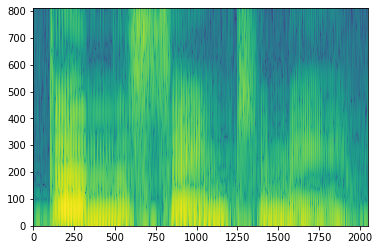

In [368]:
plt.pcolormesh(to_spec(torch.tensor(ref.copy())).log())

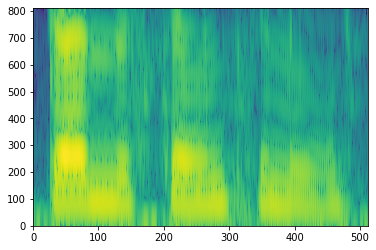

In [369]:
plt.pcolormesh(to_spec(torch.tensor(ref_small.copy())).log())

## STFT from Mag and Phase

In [326]:
np.isclose(torch.cat([(m * torch.cos(p)).unsqueeze(-1), 
                      (m * torch.sin(p)).unsqueeze(-1)], -1), 
           stft).mean()

0.9990152994791667

In [312]:
# ху***й code

def product(first, second):
    result = torch.empty_like(first)
    result[..., 0] = first[..., 0] * second[..., 0] -\
                     first[..., 1] * second[..., 1]
    result[..., 1] = first[..., 0] * second[..., 1] +\
                     first[..., 1] * second[..., 0]
    return result
def from_real_and_imag(real, imag):
    assert real.shape == imag.shape
    result = torch.stack([real, imag])
    result = result.permute(*cycle_permutation(real.dim() + 1, True))
    return result
def cycle_permutation(n, backward):
    if not backward:
        permutation = [n - 1] + list(range(n - 1))
    else:
        permutation = list(range(1, n)) + [0]
    return permutation
def phase(angle):
    cos = torch.cos(angle)
    sin = torch.sin(angle)
    return from_real_and_imag(cos, sin)

stft_pred = product(
            from_real_and_imag(
                m, torch.zeros_like(m)
            ),
            phase(torchaudio.functional.angle(stft)))

True

In [329]:
np.isclose(stft_pred, stft).mean()

0.9990152994791667

## Wave from STFT 

### istft

In [331]:
np.isclose(torchaudio.functional.istft(
        torch.cat([(m * torch.cos(p)).unsqueeze(-1),
                   (m * torch.sin(p)).unsqueeze(-1)], -1), **spec_kwargs), ref[:16377]).mean()

1.0

In [327]:
np.isclose(torchaudio.functional.istft(stft_pred, **spec_kwargs), ref[:16377]).mean()

1.0

In [346]:
IPython.display.Audio(torchaudio.functional.istft(stft_pred, **spec_kwargs), rate=rate)

### Griffin-Lim (from spectrogram)

In [341]:
to_wave = torchaudio.transforms.GriffinLim(**spec_kwargs)

In [345]:
IPython.display.Audio(to_wave(spec), rate=rate)

In [ ]:
def run_epoch():
    
    
    for bidx, batch in enumerate(dloader, 1):
        uttname, clean, noisy, slice_idx = batch
        

In [ ]:
import torch
from torch.nn.utils import clip_grad_norm_
from external_modules import torch_audio
from utils import complex_torch

    def step(self, *args, train=True):
        to_return = {}
        x, y = args
        x_stft = torch.stft(x, **self.stft_kwargs)
        y_stft = torch.stft(y, **self.stft_kwargs)
        mask = self.model(x_stft)
        assert mask.shape == x_stft.shape
        stft_pred = complex_torch.product(x_stft, mask)

        stft_pred_flat = stft_pred.reshape(stft_pred.shape[0], -1)
        stft_true_flat = y_stft.reshape(y_stft.shape[0], -1)
        

        model_out = torchaudio.istft(
            stft_pred,
            **self.stft_kwargs
        )
        true_out = torchaudio.istft(y_stft, **self.stft_kwargs)
        metric = self.metric(model_out, true_out)
        assert metric.dim() >= 1
        to_return['metric'] = metric.detach().cpu().numpy()
        if train:
            self.optimizer.zero_grad()
            loss.mean().backward()
            grad_norm = clip_grad_norm_(
                self.model.parameters(), self.max_grad_norm)
            to_return['grad_norm'] = grad_norm
            self.optimizer.step()
        return to_return


In [ ]:
# for bidx, batch in enumerate(dloader, start=1):
#     uttname, clean, noisy, slice_idx = batch
#     clean = clean.unsqueeze(1)
#     noisy = noisy.unsqueeze(1)
#     label.resize_(clean.size(0)).fill_(1)
#     clean = clean.to(device)
#     noisy = noisy.to(device)

In [ ]:
# from segan_pytorch.segan.datasets import se_dataset
# dset = se_dataset.SEDataset(clean_dir, noisy_dir, 0, slice_size=270)
# dloader = DataLoader(dset, batch_size=batch_size,
#                          shuffle=True, num_workers=num_workers,
#                          pin_memory=True,
#                          collate_fn=se_dataset.collate_fn)
# for bidx, batch in enumerate(dloader, start=1):
#     uttname, clean, noisy, slice_idx = batch
#     print(clean.shape)
#     break